# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import scipy
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
#from dotenv import load_dotenv
import os
#import boto3
#from io import BytesIO

/home/avoskov/py-3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
load_dotenv(".env")

In [ ]:
session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="ru-central1",
)

s3 = session.client(
    "s3", 
    endpoint_url=os.getenv("S3_ENDPOINT_URL"))

In [2]:
# Путь к бакету и ключам
BUCKET_NAME = "s3-student-mle-20241219-9c48261c0c"
ITEMS_KEY = "recsys/data/items.parquet"
EVENTS_KEY = "recsys/data/events.parquet"

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
# Чтение данных о треках
tracks = pd.read_parquet('tracks.parquet')
# Чтение данных о названиях
catalog_names = pd.read_parquet('catalog_names.parquet')
# Чтение данных о взаимодействиях пользователей
interactions = pd.read_parquet('interactions.parquet')

In [4]:
print(tracks[["track_id", "albums", "artists", "genres"]].sample(5, random_state=52).sort_values("track_id").set_index("track_id").to_string())

                          albums           artists        genres
track_id                                                        
88957     [8201, 88361, 6045574]            [3543]  [11, 44, 75]
46257838               [6233977]         [4383623]       [3, 75]
48263278      [6575614, 7058305]  [678505, 611169]          [68]
61200248               [9527234]          [915312]          [11]
97110155              [19968185]         [4172355]     [14, 102]


In [5]:
print(catalog_names[["id", "type", "name"]].sample(5, random_state=52).sort_values("id").set_index("id").to_string())

           type                      name
id                                       
87080     album                  El Cielo
4989459   album             Edm Club Hits
9088932   track  Let´s Make A Night Of It
37540174  track                Чертополох
69405644  track             A Lucid Dream


In [6]:
print(interactions[["user_id", "track_id", "track_seq", "started_at"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "track_id"]).to_string())

                  track_seq started_at
user_id track_id                      
46179   29544272         37 2022-11-23
70117   28213677       1055 2022-09-18
72819   85090862        270 2022-08-08
471152  55682            18 2022-09-10
688081  220497          211 2022-02-22


In [7]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [8]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [9]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [11]:
# Проверка на наличие пустых списков
empty_albums = tracks[tracks['albums'].apply(len) == 0]
empty_artists = tracks[tracks['artists'].apply(len) == 0]
empty_genres = tracks[tracks['genres'].apply(len) == 0]

print(f"Треки с пустыми альбомами: {len(empty_albums)}")
print(f"Треки с пустыми исполнителями: {len(empty_artists)}")
print(f"Треки с пустыми жанрами: {len(empty_genres)}")

Треки с пустыми альбомами: 18
Треки с пустыми исполнителями: 15369
Треки с пустыми жанрами: 3687


In [12]:
tracks['track_id'] = tracks['track_id'].astype('int32')

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

<div class="alert alert-success">
<h2> Комментарий студента</h2>

1) Выводы:
 - Данные разрознены по типам tracs и interactions
 - Есть пустые значения в tracs
 - Слишком большой DataSet interactions

2) Действия:
 - Привел все идентификаторы к типу int32.
 - после объединения tracs и catalog_names пустые значения заполню строками типа Unknown Album и т.д.
 - взял только те треки которые вошли в топ 25 у пользователя. (interactions = interactions.query("track_seq <= 25")).Получилось 30983548

</div>

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [4]:
# Подсчет количества прослушиваний для каждого трека
track_play_counts = interactions['track_id'].value_counts()

# Описание распределения
print(track_play_counts.describe())

count    1000000.000000
mean         222.629898
std         1369.930708
min            5.000000
25%            9.000000
50%           19.000000
75%           67.000000
max       111062.000000
Name: count, dtype: float64


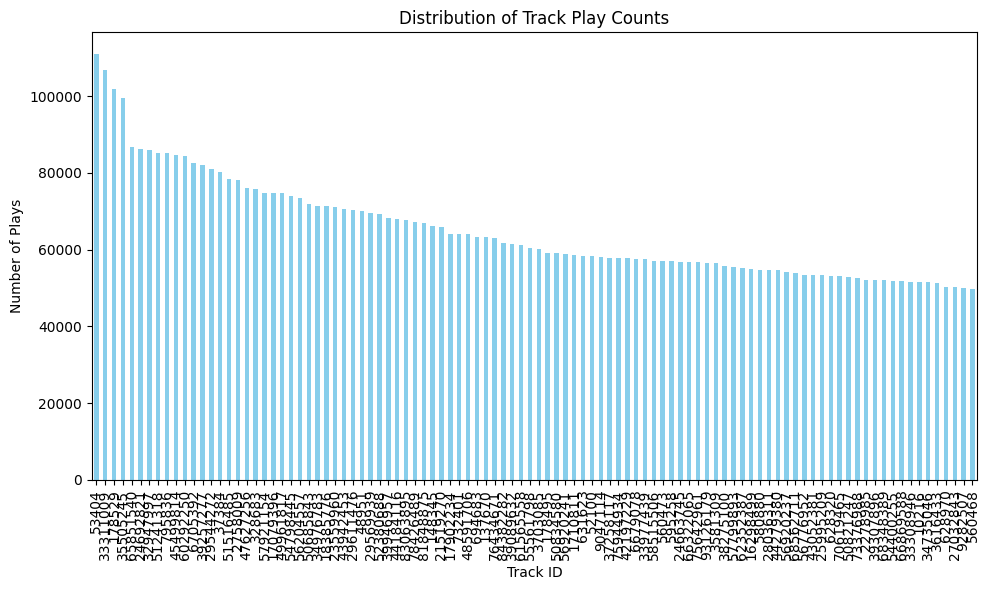

In [5]:
# Сортируем данные по количеству прослушиваний
track_play_counts_sorted = track_play_counts.sort_values(ascending=False).head(100)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
track_play_counts_sorted.plot(kind='bar', color='skyblue')
plt.xlabel('Track ID')
plt.ylabel('Number of Plays')
plt.title('Distribution of Track Play Counts')
plt.xticks(rotation=90)
plt.tight_layout()

# Показать график
plt.show()

Наиболее популярные треки

In [6]:
# Получение 10 самых популярных треков
most_popular_tracks = track_play_counts.head(10)
print(most_popular_tracks)

track_id
53404       111062
33311009    106921
178529      101924
35505245     99490
65851540     86670
24692821     86246
32947997     85886
51241318     85244
795836       85042
45499814     84748
Name: count, dtype: int64


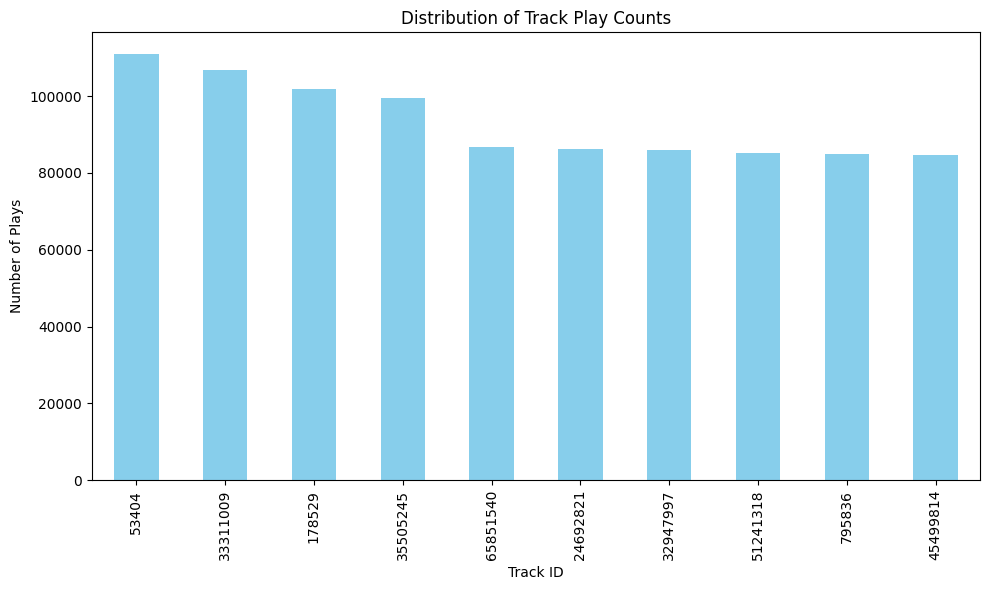

In [7]:
# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
most_popular_tracks.plot(kind='bar', color='skyblue')
plt.xlabel('Track ID')
plt.ylabel('Number of Plays')
plt.title('Distribution of Track Play Counts')
plt.xticks(rotation=90)
plt.tight_layout()

# Показать график
plt.show()

Наиболее популярные жанры

In [10]:
# Объединение таблиц для получения названий жанров
genre_counts = tracks.explode('genres').merge(catalog_names[catalog_names['type'] == 'genre'], left_on='genres', right_on='id', how='left')
genre_counts = genre_counts['name'].value_counts()

In [11]:
# Получение 10 самых популярных жанров
most_popular_genres = genre_counts.head(10)
print(most_popular_genres)

name
pop            166285
rap            128212
allrock        118509
electronics    114245
metal           72311
rusrap          65958
foreignrap      59778
rock            55177
dance           51631
ruspop          46707
Name: count, dtype: int64


/tmp/ipykernel_1897646/332841255.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_popular_genres.values, y=most_popular_genres.index, palette="viridis")


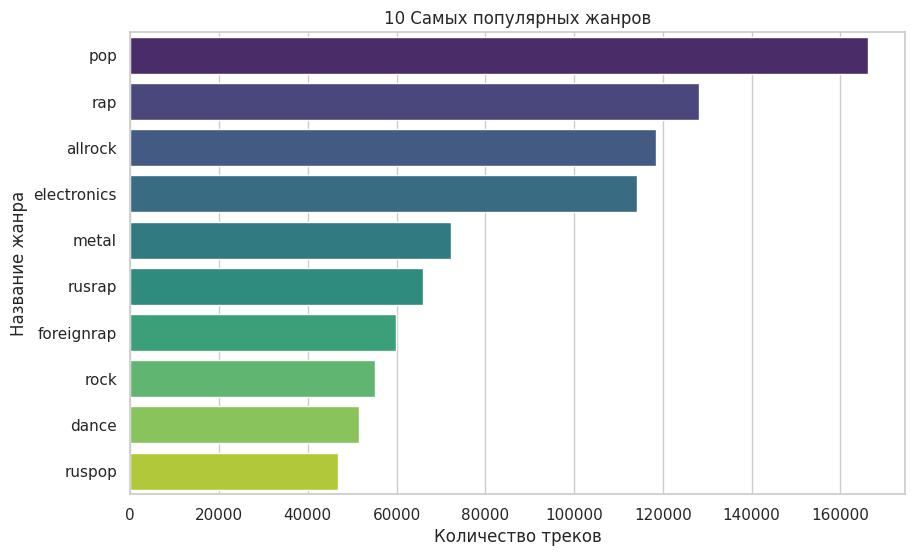

In [12]:
# Установка стиля seaborn
sns.set(style="whitegrid")

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))  # Установка размера фигуры
sns.barplot(x=most_popular_genres.values, y=most_popular_genres.index, palette="viridis")

# Добавление заголовка и меток осей
plt.title('10 Самых популярных жанров')
plt.xlabel('Количество треков')
plt.ylabel('Название жанра')

# Отображение графика
plt.show()

Треки, которые никто не прослушал

In [13]:
# Получение треков, которых нет в interactions
unheard_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]
print(f"Количество треков, которые никто не прослушал: {len(unheard_tracks)}")

Количество треков, которые никто не прослушал: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [17]:
# Создание словарей для быстрого доступа к именам
artist_names = dict(catalog_names[catalog_names['type'] == 'artist'][['id', 'name']].values)
album_names = dict(catalog_names[catalog_names['type'] == 'album'][['id', 'name']].values)
genre_names = dict(catalog_names[catalog_names['type'] == 'genre'][['id', 'name']].values)

In [18]:
# Функция для замены идентификаторов именами
def replace_ids_with_names(ids, names_dict):
    return [names_dict.get(id, 'Unknown') for id in ids]

In [19]:
# Применение функции к столбцам
tracks['artists'] = tracks['artists'].apply(lambda ids: replace_ids_with_names(ids, artist_names))
tracks['albums'] = tracks['albums'].apply(lambda ids: replace_ids_with_names(ids, album_names))
tracks['genres'] = tracks['genres'].apply(lambda ids: replace_ids_with_names(ids, genre_names))

In [20]:
# Переименование столбцов для ясности
tracks.rename(columns={
    'albums': 'album_names',
    'artists': 'artist_names',
    'genres': 'genre_names'
}, inplace=True)

In [21]:
tracks=tracks.explode("album_names")

In [22]:
tracks=tracks.explode("artist_names")

In [23]:
tracks=tracks.explode("genre_names")

In [24]:
tracks = tracks.drop_duplicates()

In [25]:
tracks["album_names"] = tracks["album_names"].fillna("Unknown Album")
tracks['artist_names'] = tracks['artist_names'].fillna("Unknown Singer")
tracks['genre_names'] = tracks['genre_names'].fillna("Unknown Genre")

In [26]:
interactions = interactions.query("track_seq <= 25")

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [27]:
tracks.to_parquet(ITEMS_KEY)
interactions.to_parquet(EVENTS_KEY)

In [ ]:
# Сохранение данных о треках в BytesIO
buffer_items = BytesIO()
tracks.to_parquet(buffer_items, engine='pyarrow')
buffer_items.seek(0)

# Загрузка данных о треках в S3
s3.put_object(
    Bucket=BUCKET_NAME,
    Key=ITEMS_KEY,
    Body=buffer_items.getvalue()
)

In [ ]:
# Сохранение взаимодействий в BytesIO
buffer_events = BytesIO()
interactions.to_parquet(buffer_events, engine='pyarrow')
buffer_events.seek(0)

# Загрузка данных о взаимодействиях в S3
s3.put_object(
    Bucket=BUCKET_NAME,
    Key=EVENTS_KEY,
    Body=buffer_events.getvalue()
)

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [28]:
# Удаление ненужных переменных
del interactions
del catalog_names
del tracks

# Принудительная сборка мусора
import gc
gc.collect()

3

### Шаги для перезапуска ядра:

1. Перейдите в меню Jupyter Notebook: Kernel -> Restart Kernel.

2. Выберите опцию Restart and clear output, если хотите очистить все выводы ячеек.

3. После перезапуска ядра выполните секцию Инициализация и продолжите с этапа 3.

- После перезапуска ядра выполните необходимые начальные секции, которые настраивают сессию boto3 и загружают необходимые данные из S3:

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [ ]:
# Загрузка items.parquet
response = s3.get_object(Bucket=BUCKET_NAME, Key=ITEMS_KEY)
buffer_items = BytesIO(response['Body'].read())
items = pd.read_parquet(buffer_items)

In [ ]:
# Загрузка events.parquet
response = s3.get_object(Bucket=BUCKET_NAME, Key=EVENTS_KEY)
buffer_events = BytesIO(response['Body'].read())
events = pd.read_parquet(buffer_events)

In [29]:
# Чтение данных о треках
items = pd.read_parquet('recsys/data/items.parquet')
# Чтение данных о названиях
events = pd.read_parquet('recsys/data/events.parquet')

In [2]:
# Чтение данных о треках
recomend = pd.read_parquet('recsys/recommendations/recommendations.parquet')
# Чтение данных о названиях
als = pd.read_parquet('recsys/recommendations/als_recommendations.parquet')

sim = pd.read_parquet('recsys/recommendations/similar.parquet')

top_pop = pd.read_parquet('recsys/recommendations/top_popular.parquet')

In [3]:
recomend.head(10)

,user_id,track_id,track_seq,target,listens_years,tracks_listen,rating_avg,rating_std,tracks_per_year,score,rank
72580,15,9563114,0.110771,0,0.013689,20,15.5,5.916080,1461.000000,0.221865,1
0,15,19606944,0.066244,1,0.013689,20,15.5,5.916080,1461.000000,0.170239,2
72581,15,19801149,0.074585,0,0.013689,20,15.5,5.916080,1461.000000,0.144947,3
72579,15,6098688,0.072530,0,0.013689,20,15.5,5.916080,1461.000000,0.133838,4
72582,15,2772886,0.072067,0,0.013689,20,15.5,5.916080,1461.000000,0.133838,5
72583,32,79071657,0.220024,0,0.038330,6,21.5,1.870829,156.535714,0.438233,1
72586,32,38633706,0.219503,0,0.038330,6,21.5,1.870829,156.535714,0.438233,2
72584,32,76434671,0.332538,0,0.038330,6,21.5,1.870829,156.535714,0.430142,3
72585,32,32476894,0.229904,0,0.038330,6,21.5,1.870829,156.535714,0.425301,4
1,32,93390818,0.196666,1,0.038330,6,21.5,1.870829,156.535714,0.420568,5


In [8]:
recomend["user_id"].nunique()

47453

In [5]:
sim.head(10)

,track_seq,item_id_1,item_id_2
1,0.971078,99262,99245
2,0.962948,99262,99254
3,0.956713,99262,99241
4,0.955401,99262,99257
5,0.947100,99262,99261
6,0.932928,99262,99252
7,0.927500,99262,99247
8,0.925771,99262,99250
9,0.896378,99262,95142
10,0.896351,99262,99239


In [4]:
top_pop.head(10)

,track_id,user_id,median_rating,users_norm,median_rating_norm,track_seq,album_names,artist_names,genre_names
0,53404,89299,6.0,1.0,0.208333,0.208333,Nevermind,Nirvana,alternative
1,53404,89299,6.0,1.0,0.208333,0.208333,Nevermind,Nirvana,rock
2,53404,89299,6.0,1.0,0.208333,0.208333,Nevermind,Nirvana,allrock
3,53404,89299,6.0,1.0,0.208333,0.208333,Nirvana,Nirvana,alternative
4,53404,89299,6.0,1.0,0.208333,0.208333,Nirvana,Nirvana,rock
5,53404,89299,6.0,1.0,0.208333,0.208333,Nirvana,Nirvana,allrock
6,53404,89299,6.0,1.0,0.208333,0.208333,Skiing Music,Nirvana,alternative
7,53404,89299,6.0,1.0,0.208333,0.208333,Skiing Music,Nirvana,rock
8,53404,89299,6.0,1.0,0.208333,0.208333,Skiing Music,Nirvana,allrock
9,53404,89299,6.0,1.0,0.208333,0.208333,Smells Like Teen Spirit / In Bloom / On A Plai...,Nirvana,alternative


In [6]:
als.head(10)

,user_id,track_id,track_seq
0,0,597196,0.344734
1,0,6006252,0.344717
2,0,16815100,0.283405
3,0,9552028,0.282132
4,0,15397472,0.277151
5,0,10016611,0.261421
6,0,16408714,0.256076
7,0,15397485,0.248963
8,0,20045346,0.248808
9,0,2211420,0.248393


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [30]:
# Преобразуем столбец started_at в datetime
events['started_at'] = pd.to_datetime(events['started_at'])

In [31]:
from datetime import datetime

In [32]:
# Разделение данных
train_cutoff_date = datetime(2022, 12, 16)
events_train = events[events['started_at'] < train_cutoff_date]
events_test = events[events['started_at'] >= train_cutoff_date]

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [33]:
# Задаем дату начала для подсчета популярности
top_pop_start_date = pd.to_datetime("2020-01-01").date()

In [34]:
# Группируем события по item_id и вычисляем количество уникальных пользователей и средний рейтинг
item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["track_id"]).agg(user_id=("user_id", "nunique"), median_rating=("track_seq", "median")).reset_index()

In [35]:
# Нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm", "median_rating_norm"]] = scaler.fit_transform(
    item_popularity[["user_id", "median_rating"]]
)

In [37]:
# Вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
item_popularity["track_seq"] = (
    item_popularity["users_norm"] * item_popularity["median_rating_norm"]
)


In [38]:
# Сортируем по убыванию track_seq
item_popularity = item_popularity.sort_values(by="track_seq", ascending=False).reset_index(drop=True)

In [39]:
# Выбираем первые 100 айтемов
top_k_pop_items = item_popularity.head(100)

In [40]:
# добавляем информацию о треках
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("track_id")[["album_names", "artist_names", "genre_names"]], on="track_id")

In [41]:
top_k_pop_items.to_parquet('recsys/recommendations/top_popular.parquet')

# Персональные

Рассчитаем персональные рекомендации.

In [42]:
# Перекодируем идентификаторы пользователей:
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])


/tmp/ipykernel_1897646/3200732168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_1897646/3200732168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])


In [43]:
# Перекодируем идентификаторы объектов:
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

/tmp/ipykernel_1897646/2277916398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
/tmp/ipykernel_1897646/2277916398.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])


In [44]:
# Определяем параметры для ALS-модели
factors = 50
iterations = 50
regularization = 0.05
random_state = 0

In [45]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)

In [46]:
# Инициализируем и обучаем ALS-модель
als_model = AlternatingLeastSquares(factors=factors, iterations=iterations, regularization=regularization, random_state=random_state, num_threads=10)
als_model.fit(user_item_matrix_train)

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


In [47]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [48]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=50)

In [49]:
# преобразуем полученные рекомендации в табличный формат
track_id_enc = als_recommendations[0]
track_seq_scores = als_recommendations[1]



In [50]:
als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": track_id_enc.tolist(), 
    "track_seq": track_seq_scores.tolist()})
als_recommendations = als_recommendations.explode(["track_id_enc", "track_seq"], ignore_index=True) 

In [51]:
# приводим типы данных
als_recommendations["track_id_enc"] = als_recommendations["track_id_enc"].astype("int")
als_recommendations["track_seq"] = als_recommendations["track_seq"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "track_id_enc"])

In [52]:
als_recommendations = als_recommendations[["user_id", "track_id", "track_seq"]]
als_recommendations.to_parquet("recsys/recommendations/als_recommendations.parquet") 

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [53]:
# Определяем максимальное количество похожих объектов
max_similar_items = 10

# Получаем энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['track_id_enc'].unique()

# Получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items + 1)

In [54]:
# преобразуем полученные списки в табличный формат
sim_item_track_id_enc = similar_items[0]
sim_track_seq = similar_items[1]

In [55]:
similar_items = pd.DataFrame({
    "item_id_enc":train_item_ids_enc.tolist(),
    "sim_item_id_enc": sim_item_track_id_enc.tolist(), 
    "track_seq": sim_track_seq.tolist()})

In [56]:
similar_items = similar_items.explode(["sim_item_id_enc", "track_seq"], ignore_index=True)

In [57]:
# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["track_seq"] = similar_items["track_seq"].astype("float")

In [58]:
# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

In [59]:
# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [60]:
similar_items.to_parquet("recsys/recommendations/similar.parquet") 

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [61]:
# разделяем данные на две части
events_labels = events_test

In [62]:
events_labels["target"] = 1

/tmp/ipykernel_1897646/3691167316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_labels["target"] = 1


In [63]:
candidates = als_recommendations.merge(events_labels[["user_id", "track_id", "target"]], 
                              on=["user_id", "track_id"], 
                              how="left")

In [64]:
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [65]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [66]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),  # положительные примеры
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

/tmp/ipykernel_1897646/4008438010.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(negatives_per_user, random_state=0))


In [67]:
def get_user_features(events):
    """ Считает пользовательские признаки """
    user_features = events.groupby("user_id").agg(
        listens_years=("started_at", lambda x: (x.max() - x.min()).days / 365.25),
        tracks_listen=("track_id", "nunique"), 
        rating_avg=("track_seq", "mean"),
        rating_std=("track_seq", "std")
    )
    user_features["tracks_per_year"] = user_features["tracks_listen"] / user_features["listens_years"]
    return user_features

In [68]:
user_features_for_train = get_user_features(events_train)

In [69]:
user_features_for_test = get_user_features(events_test)

In [70]:
candidates_final = candidates_for_train.merge(user_features_for_train, 
                              on=["user_id"], 
                              how="left")

In [71]:
candidates_final_rank = candidates_for_train.merge(user_features_for_test, 
                              on=["user_id"], 
                              how="left")

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [72]:
# задаём имена колонок признаков и таргета
features = ['track_seq', 'listens_years', 'tracks_listen', 'rating_avg', 'rating_std', 'tracks_per_year']
target = 'target'

In [73]:
# Create the Pool object
train_data = Pool(
    data=candidates_final[features], 
    label=candidates_final[target])

In [74]:
test_data = Pool(
    data=candidates_final_rank[features], 
    label=candidates_final_rank[target])

In [75]:
# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

In [76]:
# тренируем модель
cb_model.fit(train_data) 

0:	learn: 0.6712596	total: 55.4ms	remaining: 55.4s
100:	learn: 0.5758341	total: 438ms	remaining: 3.9s
200:	learn: 0.5745604	total: 821ms	remaining: 3.26s
300:	learn: 0.5735198	total: 1.22s	remaining: 2.83s
400:	learn: 0.5725681	total: 1.61s	remaining: 2.41s
500:	learn: 0.5717211	total: 2.02s	remaining: 2.01s
600:	learn: 0.5709301	total: 2.42s	remaining: 1.6s
700:	learn: 0.5701154	total: 2.82s	remaining: 1.2s
800:	learn: 0.5693752	total: 3.22s	remaining: 799ms
900:	learn: 0.5686716	total: 3.62s	remaining: 398ms
999:	learn: 0.5680327	total: 4.02s	remaining: 0us


In [77]:
predictions = cb_model.predict_proba(test_data)

In [78]:
# сохраняем вероятности положительного класса (второй столбец)
candidates_final_rank["score"] = predictions[:, 1]

In [80]:
# сортируем кандидатов по пользователю и по убыванию cb_score
candidates_final_rank = candidates_final_rank.sort_values(["user_id", "score"], ascending=[True, False])

In [81]:
# проставляем ранк, начиная с 1 для каждого пользователя
candidates_final_rank["rank"] = candidates_final_rank.groupby("user_id").cumcount() + 1

In [82]:
candidates_final_rank.to_parquet("recsys/recommendations/recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [83]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "track_seq"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(events_train["track_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "track_seq"]], 
        on=["user_id", "track_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["track_seq"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [84]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    # Группируем данные по user_id
    groupper = events_recs_for_binary_metric.groupby("user_id")
    
    # Вычисляем precision@5 и recall@5 для каждого пользователя
    #precision_5 = groupper.apply(lambda df: df['tp'].head(5).sum() / (df['tp'].head(5).sum() + df['fp'].head(5).sum()) if (df['tp'].head(5).sum() + df['fp'].head(5).sum()) > 0 else 0)
    #ecall_5 = groupper.apply(lambda df: df['tp'].head(5).sum() / (df['tp'].head(5).sum() + df['fn'].head(5).sum()) if (df['tp'].head(5).sum() + df['fn'].head(5).sum()) > 0 else 0)

    # precision = tp / (tp + fp)
    precision_5 = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision_5 = precision_5.fillna(0).mean()

    # Вычисляем precision@10 и recall@10 для каждого пользователя
   # precision_10 = groupper.apply(lambda df: df['tp'].head(10).sum() / (df['tp'].head(10).sum() + df['fp'].head(10).sum()) if (df['tp'].head(10).sum() + df['fp'].head(10).sum()) > 0 else 0)
   # recall_10 = groupper.apply(lambda df: df['tp'].head(10).sum() / (df['tp'].head(10).sum() + df['fn'].head(10).sum()) if (df['tp'].head(10).sum() + df['fn'].head(10).sum()) > 0 else 0)
    
    # precision = tp / (tp + fp)
    recall_5 = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall_5 = recall_5.fillna(0).mean()
    
    # Вычисляем среднее по всем пользователям
    #precision_5 = precision_5.mean()
    #recall_5 = recall_5.mean()
    
  #  precision_10 = precision_10.mean()
  #  recall_10 = recall_10.mean()

    return precision_5, recall_5

In [85]:
als_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
  events_test, 
  als_recommendations, 
  top_k=5
)

/tmp/ipykernel_1897646/2318076430.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 270726


/tmp/ipykernel_1897646/2318076430.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [86]:
precision_als, recall_als = compute_cls_metrics(als_binary_metrics)

In [87]:
top_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
  events_test, 
  top_k_pop_items, 
  top_k=5
)

Common users: 25


/tmp/ipykernel_1897646/2318076430.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_1897646/2318076430.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [88]:
precision_top, recall_top = compute_cls_metrics(top_binary_metrics)

In [89]:
cbl_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
  events_test, 
  candidates_final_rank, 
  top_k=5
)

/tmp/ipykernel_1897646/2318076430.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 47453


/tmp/ipykernel_1897646/2318076430.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [90]:
precision_cbl, recall_cbl = compute_cls_metrics(cbl_binary_metrics)

In [91]:
als_top = als_recommendations.sort_values(['user_id', 'track_id'], ascending=[True, False])
# Получение всех уникальных item_id
all_items = set(als_top['track_id'].unique())
# Получение первых 100 строк
first_100_rows = als_top.head(100)
# Получение уникальных item_id из первых 100 строк
recommended_items = set(first_100_rows['track_id'].unique())
# Вычисление Item Coverage
als_coverage = len(recommended_items) / len(all_items)

In [92]:
top_k_pop_top = top_k_pop_items.sort_values(['user_id', 'track_id'], ascending=[True, False])
# Получение всех уникальных item_id
all_items = set(top_k_pop_top['track_id'].unique())
# Получение первых 100 строк
first_100_rows = top_k_pop_top.head(100)
# Получение уникальных item_id из первых 100 строк
recommended_items = set(first_100_rows['track_id'].unique())
# Вычисление Item Coverage
top_k_pop_coverage = len(recommended_items) / len(all_items)

In [93]:
cbl_top = candidates_final_rank.sort_values(['user_id', 'track_id'], ascending=[True, False])
# Получение всех уникальных item_id
all_items = set(cbl_top['track_id'].unique())
# Получение первых 100 строк
first_100_rows = cbl_top.head(100)
# Получение уникальных item_id из первых 100 строк
recommended_items = set(first_100_rows['track_id'].unique())
# Вычисление Item Coverage
cbl_coverage = len(recommended_items) / len(all_items)

In [94]:
# Шаг 1: Разметим каждую рекомендацию булевым признаком read, используя данные из events_train
events_train["listen"] = True

/tmp/ipykernel_1897646/4294728115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["listen"] = True


In [95]:
als_recommendations = als_recommendations.merge(events_train[["user_id", "track_id", "listen"]], on=["user_id", "track_id"], how="left")
als_recommendations["listen"] = als_recommendations["listen"].fillna(False).astype("bool")

/tmp/ipykernel_1897646/599951557.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  als_recommendations["listen"] = als_recommendations["listen"].fillna(False).astype("bool")


In [96]:
# Шаг 2: Проставим ранги для рекомендаций каждого пользователя
als_recommendations = als_recommendations.sort_values(by=["user_id", "track_seq"], ascending=[True, False])  
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

In [ ]:
# Шаг 3: Посчитаем novelty@5 для каждого пользователя
novelty_als = (1 - als_recommendations.query("rank <= 5").groupby("user_id")["listen"].mean())

In [98]:
# Шаг 4: Посчитаем среднее значение novelty@5
average_novelty_als = novelty_als.mean()

In [99]:
top_k_pop_items = top_k_pop_items.merge(events_train[["user_id", "track_id", "listen"]], on=["user_id", "track_id"], how="left")
top_k_pop_items["listen"] = top_k_pop_items["listen"].fillna(False).astype("bool")

/tmp/ipykernel_1897646/1414846396.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  top_k_pop_items["listen"] = top_k_pop_items["listen"].fillna(False).astype("bool")


In [100]:
# Шаг 2: Проставим ранги для рекомендаций каждого пользователя
top_k_pop_items = top_k_pop_items.sort_values(by=["user_id", "track_seq"], ascending=[True, False])  
top_k_pop_items["rank"] = top_k_pop_items.groupby("user_id").cumcount() + 1

In [101]:
# Шаг 3: Посчитаем novelty@5 для каждого пользователя
novelty_top = (1 - top_k_pop_items.query("rank <= 5").groupby("user_id")["listen"].mean())

In [102]:
# Шаг 4: Посчитаем среднее значение novelty@5
average_novelty_top = novelty_top.mean()

In [103]:
candidates_final_rank = candidates_final_rank.merge(events_train[["user_id", "track_id", "listen"]], on=["user_id", "track_id"], how="left")
candidates_final_rank["listen"] = candidates_final_rank["listen"].fillna(False).astype("bool")

/tmp/ipykernel_1897646/2443919558.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  candidates_final_rank["listen"] = candidates_final_rank["listen"].fillna(False).astype("bool")


In [104]:
# Шаг 3: Посчитаем novelty@5 для каждого пользователя
novelty_cbl = (1 - candidates_final_rank.query("rank <= 5").groupby("user_id")["listen"].mean())

In [105]:
# Шаг 4: Посчитаем среднее значение novelty@5
average_novelty_cbl = novelty_cbl.mean()

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [106]:
print(f"Precision@5_als: {precision_als:.3f}")
print(f"Recall@5_als: {recall_als:.3f}")
print(f"Precision@5_top: {precision_top:.3f}")
print(f"Recall@5_top: {recall_top:.3f}")
print(f"Precision@5_cbl: {precision_cbl:.3f}")
print(f"Recall@5_cbl: {recall_cbl:.3f}")

Precision@5_als: 0.005
Recall@5_als: 0.008
Precision@5_top: 0.000
Recall@5_top: 0.000
Precision@5_cbl: 0.258
Recall@5_cbl: 0.440


In [107]:
print(f"ALS Coverage для первых 100 строк: {als_coverage:.2f}")
print(f"TOP Coverage для первых 100 строк: {top_k_pop_coverage:.2f}")
print(f"CBL Coverage для первых 100 строк: {cbl_coverage:.2f}")

ALS Coverage для первых 100 строк: 0.02
TOP Coverage для первых 100 строк: 0.01
CBL Coverage для первых 100 строк: 0.03


In [108]:
print(f" Als Novelty@5: {average_novelty_als:.2f}")
print(f" Top Novelty@5: {average_novelty_top:.2f}")
print(f" CBl Novelty@5: {average_novelty_cbl:.2f}")

 Als Novelty@5: 0.71
 Top Novelty@5: 0.99
 CBl Novelty@5: 0.92


<div class="alert alert-success">
<h2> Комментарий студента</h2>

# На основе предоставленных метрик можно сделать следующие выводы о качестве рекомендаций трех типов:

1. Топ Популярных
#### Precision@5 и Recall@5:

- Precision@5: 0.000
- Recall@5: 0.000
### Вывод: Модель топ-популярных треков практически не предсказывает правильные треки для пользователей. Это означает, что среди первых 5 рекомендаций практически нет тех треков, которые пользователь действительно слушал.
#### Coverage:

- Coverage для первых 100 строк: 0.01
### Вывод: Модель топ-популярных треков предлагает очень ограниченный набор уникальных треков. Это может быть связано с тем, что популярные треки часто одинаковы для большинства пользователей.
#### Novelty:

- Novelty@5: 0.99
### Вывод: Большинство рекомендаций являются новыми для пользователей, но поскольку эти рекомендации не совпадают с теми треками, которые пользователи действительно слушали, это мало полезно.
2. ALS (Алгоритм Матричной Факторизации)
#### Precision@5 и Recall@5:

- Precision@5: 0.005
- Recall@5: 0.008
### Вывод: Модель ALS также предсказывает очень мало правильных треков для пользователей. Однако, она немного лучше, чем модель топ-популярных треков, хотя все еще очень низкие метрики.
#### Coverage:

- ALS Coverage для первых 100 строк: 0.02
### Вывод: Модель ALS предлагает немного больше уникальных треков по сравнению с моделью топ-популярных треков, но это все еще низкий показатель.
#### Novelty:

- Als Novelty@5: 0.71
### Вывод: Большинство рекомендаций являются новыми для пользователей, но снова это мало полезно, так как эти рекомендации не совпадают с теми треками, которые пользователи действительно слушали.
3.CatBoost (Построенная с помощью CatBoost)
#### Precision@5 и Recall@5:

- Precision@5: 0.258
- Recall@5: 0.440
### Вывод: Модель CatBoost значительно лучше, чем модели топ-популярных треков и ALS. Она предсказывает гораздо больше правильных треков среди первых 2 рекомендаций. Это означает, что рекомендации более точные и релевантные для пользователей.
#### Coverage:

- CBL Coverage для первых 100 строк: 0.03
### Вывод: Модель CatBoost предлагает больше уникальных треков по сравнению с моделями топ-популярных треков и ALS, что делает рекомендации более разнообразными.
#### Novelty:

- CBl Novelty@5: 0.92
### Вывод: Большинство рекомендаций являются новыми для пользователей, но это менее важно, чем точность и релевантность рекомендаций. Новые треки могут быть полезными для пользователей, но они не являются главным показателем качества рекомендаций.

## Общий Вывод
### Топ Популярных Треки:

Модель практически не предсказывает правильные треки для пользователей.
Предложенный набор треков очень ограничен и не разнообразен.
Большинство рекомендаций новые, но это мало полезно, так как они не совпадают с теми треками, которые пользователи действительно слушали.
### ALS (Алгоритм Матричной Факторизации):

Модель предсказывает немного больше правильных треков, но все еще очень низкие метрики.
Набор уникальных треков немного больше, но это все еще очень низкий показатель.
Большинство рекомендаций новые, но это мало полезно, так как эти рекомендации не совпадают с теми треками, которые пользователи действительно слушали.
### CatBoost (Построенная с помощью CatBoost):

Модель значительно лучше предсказывает правильные треки для пользователей.
Она предлагает больше уникальных треков по сравнению с моделями топ-популярных треков и ALS.
Большинство рекомендаций новые, но это менее важно, чем точность и релевантность рекомендаций.
Рекомендации более точные и релевантные для пользователей, что делает модель более полезной.
Рекомендации
### Использование CatBoost:

Модель CatBoost значительно лучше других моделей в предсказании правильных треков для пользователей.
Она предлагает более разнообразные и релевантные рекомендации для пользователей, что делает рекомендации более полезными.
Дополнительное Улучшение Модели:

Можно попробовать улучшить модель CatBoost с помощью дополнительных методов, таких как кросс-валидация, настройка гиперпараметров и добавление новых признаков.
Можно также попробовать комбинировать модели CatBoost с другими моделями для улучшения качества рекомендаций.
Использование Вариативных Рекомендаций:

Можно использовать комбинацию моделей для предсказания рекомендаций, чтобы улучшить качество рекомендаций.
Например, можно использовать модель CatBoost для предсказания основных треков и модели топ-популярных треков для предсказания дополнительных рекомендаций.
### Анализ Данных:

Можно провести более детальный анализ данных для понимания причин низких метрик в моделях топ-популярных треков и ALS.
Можно также провести анализ данных для понимания причин высокой точности и релевантности рекомендаций в модели CatBoost.
Таким образом, использование модели CatBoost для рекомендаций может значительно улучшить качество рекомендаций и сделать их более полезными для пользователей.

</div>